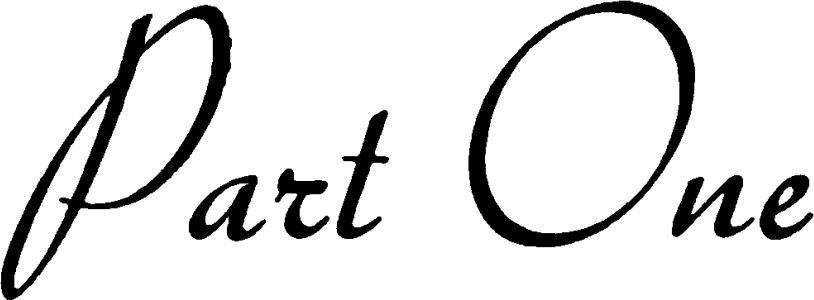

# Prepare our Json files

**Installing scrapy library**

In [1]:
!pip install scrapy

Defaulting to user installation because normal site-packages is not writeable


In [2]:
%%writefile jobs_1.py


import scrapy

class JobsSpider(scrapy.Spider):
    # Spider name
    name = "jobs"

    # List of starting URLs
    start_urls = [
        'https://tunisia.tanqeeb.com/s/jobs/jobs-in-tunisia'
    ]

    # Custom settings for the spider
    custom_settings = {
        'USER_AGENT': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36',
        'COOKIES_ENABLED': True,
        'DOWNLOAD_DELAY': 1  # Set the delay to 1 second (or adjust as needed)
    }

    # Initialize the page count
    page_count = 0
    
    # Maximum number of pages to scrape
    max_pages = 50

    # Callback function that processes the response
    def parse(self, response):
        # Check if the response status is 403 (Forbidden)
        if response.status == 403:
            self.logger.warning("Received a 403 Forbidden response. You may be blocked. Check the website's terms of service.")
            return

        # Extract job information from each 'div.card-body' element
        for job in response.css('div.card-body'):
            yield {
                'location': job.css('p.h10 > span:nth-child(1)::text').get(),
                'jobTitle': job.css('h5::text').get(),
                'company': job.css('p.h10 > span:nth-child(2)::text').get(),
                'Add Date': job.css('p.h10 > span:nth-child(3)::text').get(),
            }
        
        # Increment the page count
        self.page_count += 1

        # Check if we have scraped 300 pages, and if not, follow pagination links
        if self.page_count < self.max_pages:
            yield from response.follow_all(css='li.page-item.active > a', callback=self.parse)


Writing jobs_1.py


In [3]:
import os

# Check if the file exists before deleting it
if os.path.exists("jobs_1.json"):
    os.remove("jobs_1.json")

# Run your Scrapy spider
# this might take some time and a long output
!scrapy runspider jobs_1.py -o jobs_1.json

2023-09-16 00:03:25 [scrapy.utils.log] INFO: Scrapy 2.7.1 started (bot: scrapybot)
2023-09-16 00:03:25 [scrapy.utils.log] INFO: Versions: lxml 4.9.1.0, libxml2 2.9.14, cssselect 1.2.0, parsel 1.7.0, w3lib 2.1.0, Twisted 22.10.0, Python 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0], pyOpenSSL 22.1.0 (OpenSSL 3.0.7 1 Nov 2022), cryptography 38.0.4, Platform Linux-6.2.0-32-generic-x86_64-with-glibc2.35
2023-09-16 00:03:25 [scrapy.crawler] INFO: Overridden settings:
{'DOWNLOAD_DELAY': 1,
 'SPIDER_LOADER_WARN_ONLY': True,
 'USER_AGENT': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 '
               '(KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36'}
2023-09-16 00:03:25 [py.warnings] WARNING: /home/ryuke/.local/lib/python3.10/site-packages/scrapy/utils/request.py:231: ScrapyDeprecationWarning: '2.6' is a deprecated value for the 'REQUEST_FINGERPRINTER_IMPLEMENTATION' setting.

It is also the default value. In other words, it is normal to get this warning if you hav

In [4]:
%%writefile jobs_2.py

import scrapy

# Define a Scrapy spider class named 'jobsSpider'
class jobsSpider(scrapy.Spider):
    # Set the name of the spider
    name = "jobs"

    # Define the starting URLs for the spider
    start_urls = [
        "https://www.farojob.net/jobs"
    ]

    # Initialize a page counter
    page_counter = 0

    # Maximum number of pages to scrape
    max_pages = 50

    # Callback function to process the web page's response
    def parse(self, response):
        # Check if the response status is 403 (Forbidden)
        if response.status == 403:
            self.logger.warning("Received a 403 Forbidden response. You may be blocked. Check the website's terms of service.")
            return
            
            
        # Increment the page counter
        self.page_counter += 1

        # Extract job information from each 'article.loadmore-item' element
        for job in response.css('article.loadmore-item'):
            yield {
                'location': job.css('div.loop-item-content > p > span.job-location > a > em::text').get(),
                'jobTitle': job.css(' div.loop-item-content > h2 > a::text').get(),
                'company': job.css('div.loop-item-content > p > span.job-company > a::text').get(),
                'Add Date': job.css('div.loop-item-content > p > span.job-date > time > span::text').get(),
            }
        
        # Follow pagination links to continue scraping other pages, but stop if we've reached the maximum number of pages
        if self.page_counter < self.max_pages:
            yield from response.follow_all(css='div.pagination.list-center > a.next.page-numbers', callback=self.parse)


Writing jobs_2.py


In [5]:
import os

# Check if the file exists before deleting it
if os.path.exists("jobs_2.json"):
    os.remove("jobs_2.json")

# Run your Scrapy spider
!scrapy runspider jobs_2.py -o jobs_2.json

2023-09-16 00:04:25 [scrapy.utils.log] INFO: Scrapy 2.7.1 started (bot: scrapybot)
2023-09-16 00:04:25 [scrapy.utils.log] INFO: Versions: lxml 4.9.1.0, libxml2 2.9.14, cssselect 1.2.0, parsel 1.7.0, w3lib 2.1.0, Twisted 22.10.0, Python 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0], pyOpenSSL 22.1.0 (OpenSSL 3.0.7 1 Nov 2022), cryptography 38.0.4, Platform Linux-6.2.0-32-generic-x86_64-with-glibc2.35
2023-09-16 00:04:25 [scrapy.crawler] INFO: Overridden settings:
{'SPIDER_LOADER_WARN_ONLY': True}
2023-09-16 00:04:25 [py.warnings] WARNING: /home/ryuke/.local/lib/python3.10/site-packages/scrapy/utils/request.py:231: ScrapyDeprecationWarning: '2.6' is a deprecated value for the 'REQUEST_FINGERPRINTER_IMPLEMENTATION' setting.

It is also the default value. In other words, it is normal to get this warning if you have not defined a value for the 'REQUEST_FINGERPRINTER_IMPLEMENTATION' setting. This is so for backward compatibility reasons, but it will change in a future version of Scrapy.

# Preparing our DataFrame

In [6]:
import pandas as pd

# Define a data cleaning function
def clean_data(df):
    if df is not None:
        df['Add Date'] = df['Add Date'].str.replace('\n', '')
        df['company'] = df['company'].str.replace('\n', '')
        df['jobTitle'] = df['jobTitle'].str.replace('\n', '')
        df['location'] = df['location'].str.replace('\n', '')
    return df

# Attempt to read the JSON file
try:
    df1 = pd.read_json("jobs_1.json")
    df1 = clean_data(df1)

except Exception as e:
    print("Error reading jobs_1.json:", e)
    df1 = None

# Attempt to read the JSON file
try:
    df2 = pd.read_json("jobs_2.json")
    df2 = clean_data(df2)
except Exception as e:
    print("Error reading jobs_2.json:", e)
    df2 = None



# Check if dataframes were successfully loaded
if df1 is not None and df2 is not None:
    MyDataFrame = pd.concat([df1, df2], ignore_index=True, sort=False, axis=0)
    display(MyDataFrame)
    print("****** Information about our DataFrame ******* ")
    print(df1.info())
    print(type(MyDataFrame))
else:
    print("Dataframes could not be loaded due to JSON errors.")


,location,jobTitle,company,Add Date
0,Tunisia - Tunis,Sales Executive - Tunisia,Glovo,15 September 2023
1,Tunisia - Tunisia,Digital Marketing Specialist,Vistaprint,15 September 2023
2,Tunisia - Tunis,Housekeeping Manager,Marriott International,15 September 2023
3,Tunisia - Tunis,Sales Executive,Aramex,15 September 2023
4,None,None,None,None
...,...,...,...,...
1745,"- Les Berges du Lac II, MEDTECH Building, 4th ...",OAAS/ COMWEAVE recrute Consultant(e) en Recrut...,OAAS/ COMWEAVE,22 avril 2022
1746,"Soliman, Nabeul, Tunisie",SOFEMED INTERNATIONAL recrute Responsable Syst...,SOFEMED INTERNATIONAL,21 avril 2022
1747,Sousse,AltraCall recrute Développeur Perl H/F,AltraCall,20 avril 2022
1748,CENTRE URBAIN NORD - TUNIS,CCSAV recrute Développeur web Full Stack / Dév...,Centre Canadien de Services d’Agents Virtuels ...,15 avril 2022


****** Information about our DataFrame ******* 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   location  850 non-null    object
 1   jobTitle  850 non-null    object
 2   company   850 non-null    object
 3   Add Date  845 non-null    object
dtypes: object(4)
memory usage: 31.4+ KB
None
<class 'pandas.core.frame.DataFrame'>


# Creating a corpus

In [7]:
# Initialize an empty list to store job titles
corpus = []

# Iterate through the 'jobTitle' column of MyDataFrame
for i in MyDataFrame['jobTitle']:
    # Check if the value is not None
    if i is not None:
        # Append the non-None job title to the corpus list
        corpus.append(i)

# Print the corpus (list of job titles)
print(corpus)

['Sales Executive - Tunisia', 'Digital Marketing Specialist', 'Housekeeping Manager', 'Sales Executive', 'Product Application Engineer Drive Algeria & Tunisia', 'Events Supervisor', 'Software Validator Apprentice M/F', 'Early Years Teacher', 'FRA - SAP Payroll Consultant', 'Pre-Press Production Specialist', 'Graphic Designer', 'Business Analyst (F/H) Tunisia - Tunis - Sofrecom Tunisie', 'Cluster Development officer', 'KS1 Teacher', 'Concierge Agent', 'Ingénieur Développement Mobile (F/H)', 'DevOps Engineer', 'Chef d’équipe Testing et QA', 'Consultant Senior FSI Banque & Assurance (H/F)', 'Procurement & Logistics Manager', '* Operations Manager - NOC', 'Référent Technique (F/H)', 'Operations Manager - NOC', 'Cluster Marketing Associate', 'Cluster business development officer', 'Chargé(e) des créations fournisseurs', 'Business Analyst (F/H)', 'HR Business Partner (F/M)', 'Ingénieur Développement Mobile (F/H) Tunisia - Tunis - Sofrecom Tunisie', 'Marketing Intern PAID', 'Directeur médical

# Remove Noise Function For our DataFrame

In [8]:
!pip install nltk

Defaulting to user installation because normal site-packages is not writeable


In [9]:
# Import necessary libraries from nltk
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re

# Download required resources (punkt tokenizer and stopwords data)
nltk.download('punkt')
nltk.download('stopwords')

# Create a list of stopwords for both English and French languages
final_stopwords_list = stopwords.words('english') + stopwords.words('french')

# Define a function to remove noise from text
def remove_noise(text, stop_words=final_stopwords_list):
    # Tokenize the input text into words
    tokens = word_tokenize(text)
    cleaned_tokens = []
    for token in tokens:
        # Remove any non-alphanumeric characters
        token = re.sub('[^A-Za-z0-9]+', '', token)
        if len(token) > 1 and token.lower() not in stop_words:
            # Convert the token to lowercase and add it to the cleaned tokens list
            cleaned_tokens.append(token.lower())
    
    # Join the cleaned tokens into a single string
    cleaned_tokens = ' '.join(cleaned_tokens)
    return cleaned_tokens


[nltk_data] Downloading package punkt to /home/ryuke/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/ryuke/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Creating tfidf_matrix

In [10]:
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable


In [11]:
# Import the TfidfVectorizer class from scikit-learn's feature_extraction.text module
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize a TfidfVectorizer object
# - TfidfVectorizer is a tool for converting a collection of raw documents (in this case, job titles) to a matrix of TF-IDF features.
# - The 'tokenizer' parameter is set to 'remove_noise', which is a custom tokenization function that preprocesses the text data.
tfidf_vectorizer = TfidfVectorizer(tokenizer=remove_noise)

# Use the .fit_transform() method of the TfidfVectorizer
# - The .fit_transform() method processes the 'corpus' data (a list of job titles) and converts it into a TF-IDF matrix.
# - TF-IDF stands for Term Frequency-Inverse Document Frequency, which is a numerical statistic used in natural language processing.
# - It represents the importance of each word in relation to the entire collection of job titles.
tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)

# Print the TF-IDF matrix
# - The TF-IDF matrix contains numerical values that represent the importance of words in each job title.
# - Each row corresponds to a job title, and each column corresponds to a unique word in the entire collection.
# - The values in the matrix are the TF-IDF scores for each word in each job title.
print(tfidf_matrix)


  (0, 24)	0.12375997707489443
  (0, 32)	0.2500284292597541
  (0, 19)	0.362296116168623
  (0, 30)	0.23703183184150312
  (0, 31)	0.27150635592724265
  (0, 13)	0.12984011150989871
  (0, 34)	0.3924391307328654
  (0, 0)	0.22532406590166615
  (0, 15)	0.4470031701812135
  (0, 22)	0.14891769227337398
  (0, 11)	0.2448892577172031
  (0, 29)	0.3967544125770134
  (1, 26)	0.15639550419108483
  (1, 21)	0.27800479564185276
  (1, 28)	0.1027802867342796
  (1, 23)	0.1452916379370227
  (1, 17)	0.33458361103458556
  (1, 14)	0.1625744700687665
  (1, 24)	0.11025503823112057
  (1, 19)	0.5379360528240481
  (1, 30)	0.3167496588884581
  (1, 13)	0.11567169610732615
  (1, 0)	0.20073624840238702
  (1, 15)	0.1991126403810536
  (1, 22)	0.2653349853960467
  :	:
  (1598, 32)	0.3066855717557721
  (1598, 30)	0.14537195447703966
  (1598, 31)	0.2220203045160291
  (1598, 13)	0.26543707418352197
  (1598, 0)	0.3685108406057622
  (1598, 15)	0.41122150557901016
  (1598, 22)	0.24355047802430713
  (1598, 11)	0.15019092477244186


/home/ryuke/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


# Clustering with Kmean

In [12]:
# Import the KMeans clustering algorithm from scikit-learn
from sklearn.cluster import KMeans

# Initialize KMeans with 3 centroids (clusters)
kmeans = KMeans(n_clusters=3, random_state=47)
# 'n_clusters' specifies the number of clusters to create.
# 'random_state' is used to ensure reproducibility of results.

# Fit the KMeans model to the TF-IDF matrix
kmeans.fit(tfidf_matrix)
# This step applies the KMeans clustering algorithm to the TF-IDF matrix created earlier.
# It finds cluster assignments for each data point (job title).

# Store the cluster labels in a variable
clusters = kmeans.labels_
# After fitting the model, 'kmeans.labels_' contains the cluster assignment for each job title.

# Print the cluster labels
print(clusters)

# Create a DataFrame to store job titles and their cluster labels
MyDataFrame = pd.DataFrame(data=corpus, columns=['Job Title'])
# 'corpus' contains the job titles, and we create a DataFrame column named 'Job Title' to store them.

# Add the cluster labels to the DataFrame
MyDataFrame["Labels"] = clusters
# We add a new column 'Labels' to the DataFrame to store the cluster assignments.

# Print information about the DataFrame
print(MyDataFrame.info())
# This line prints basic information about the DataFrame, such as column names and data types.

# Sort the DataFrame based on the 'Labels' column
MyDataFrame = MyDataFrame.sort_values('Labels')
# This step sorts the DataFrame based on the cluster labels.
# It groups job titles by their assigned clusters.

# Print the sorted DataFrame
print(MyDataFrame)

# Print the type of the DataFrame
print(type(MyDataFrame))
# This line prints the type of the DataFrame, which should be 'pandas.core.frame.DataFrame'.


[1 1 1 ... 2 2 1]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Job Title  1600 non-null   object
 1   Labels     1600 non-null   int32 
dtypes: int32(1), object(1)
memory usage: 18.9+ KB
None
                                              Job Title  Labels
1174  Polyclinique Al Majed recrute des Instrumentistes       0
919   Assurances COMAR recrute Ingénieur Chargé Test...       0
419                                   Hôtesse d'accueil       0
420                                     Writer - Remote       0
1157                    CEAT recrute Technicien Routier       0
...                                                 ...     ...
1257        KH recrute Développeur Full Stack Java/J2EE       2
639                             Employé service clients       2
638                                Youtube Video Editor       2
1252  Polyclinique Al Ma

/home/ryuke/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


# Trying to visiualise Data

********************************
 [[-0.02801202  0.20595293]
 [-0.32942216  0.14500785]
 [-0.06412832  0.00441682]
 ...
 [ 0.35327858  0.02155224]
 [ 0.42987537  0.10491415]
 [-0.03125864 -0.01182855]]
                                              Job Title  Labels  cluster  \
1174  Polyclinique Al Majed recrute des Instrumentistes       0        1   
919   Assurances COMAR recrute Ingénieur Chargé Test...       0        1   
419                                   Hôtesse d'accueil       0        1   
420                                     Writer - Remote       0        2   
1157                    CEAT recrute Technicien Routier       0        1   
...                                                 ...     ...      ...   
1257        KH recrute Développeur Full Stack Java/J2EE       2        0   
639                             Employé service clients       2        1   
638                                Youtube Video Editor       2        2   
1252  Polyclinique Al Majed recrute Re

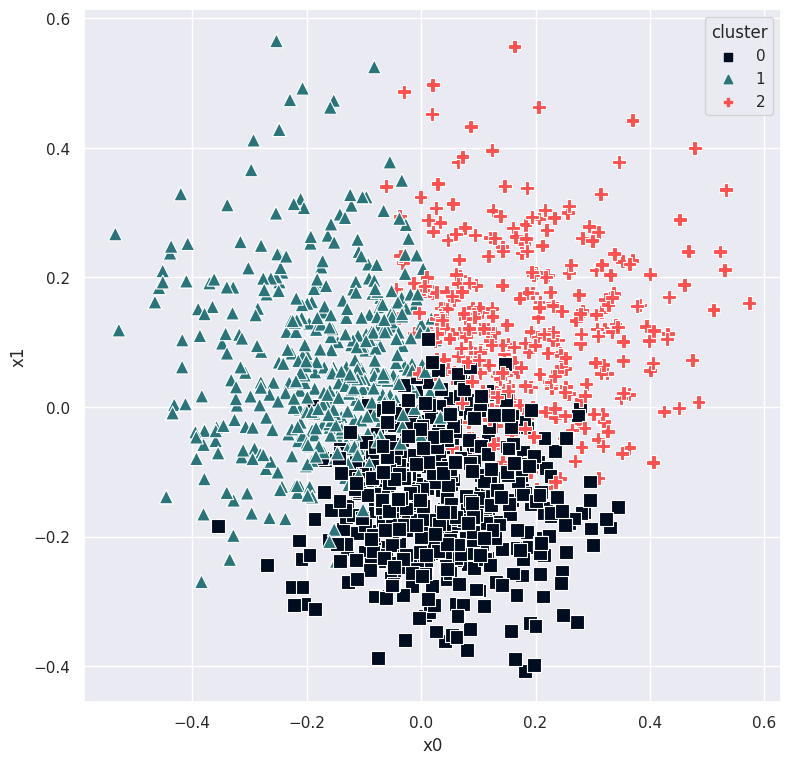

In [13]:
# Import necessary libraries for data visualization and dimensionality reduction
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Initialize PCA (Principal Component Analysis) with 2 components
pca = PCA(n_components=2, random_state=42)
# PCA is used to reduce the dimensionality of the data while preserving important information.
# In this case, it reduces the TF-IDF matrix to 2 dimensions.

# Fit PCA to the TF-IDF matrix and store the reduced vectors in 'pca_vecs'
pca_vecs = pca.fit_transform(tfidf_matrix.toarray())
# The 'toarray()' method converts the sparse TF-IDF matrix to a dense NumPy array.

# Print the reduced PCA vectors
print("********************************\n", pca_vecs)

# Extract the first and second dimensions from the reduced vectors
x0 = pca_vecs[:, 0]
x1 = pca_vecs[:, 1]

# Add cluster assignments and PCA vectors to the DataFrame
MyDataFrame['cluster'] = clusters
MyDataFrame['x0'] = x0
MyDataFrame['x1'] = x1

# Print the DataFrame with cluster assignments and PCA vectors
print(MyDataFrame)

# Define a custom color palette for the clusters
knn_palette = sns.color_palette(['#000C1F', '#29757A', '#FF5050'])
# This defines a color palette with three distinct colors for the clusters.

# Create a scatterplot to visualize the data
plt.figure(figsize=(9, 9))
sns.set()
sns.scatterplot(x='x0', y='x1',
                data=MyDataFrame,
                hue='cluster',
                palette=knn_palette,
                # Define markers for each cluster ('o', '^', 's')
                markers=[',', '^', 'P'],
                # Specify that the style parameter is based on the 'cluster' column
                style='cluster',
                # Increase the size of the points
                s=100,
                # Show the legend
                legend=True
                )
plt.show()
# This code creates a scatterplot to visualize the data in two dimensions after PCA.

# 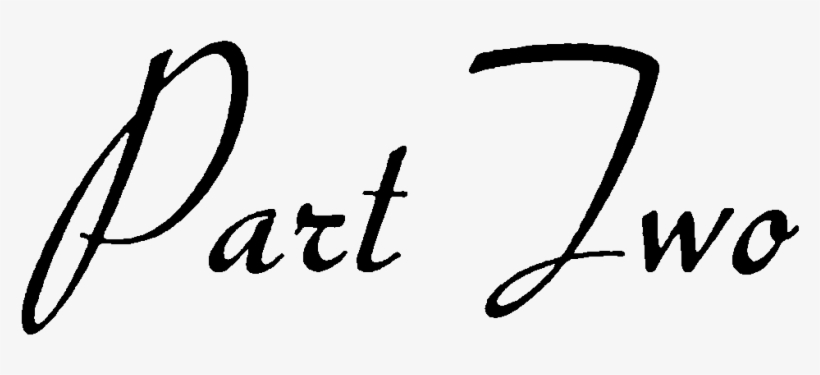

# Creating a spark context and reading the data


In [14]:
!pip install pyspark

Defaulting to user installation because normal site-packages is not writeable


In [15]:
# Import necessary libraries for working with PySpark and Pandas
import pandas as pd
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession

# Create or retrieve a SparkContext (sc) instance
sc = SparkContext.getOrCreate()
# SparkContext is the entry point for Spark functionality. It manages the resources for your Spark application.

# Create a SparkSession (spark) using the SparkContext
spark = SparkSession(sc)
# SparkSession provides a single entry point to interact with Spark functionality, including creating DataFrames.

# Read JSON data from 'jobs_1.json' and 'jobs_2.json' into Pandas DataFrames
df1 = pd.read_json("jobs_1.json")
df2 = pd.read_json("jobs_2.json")

# Concatenate the two Pandas DataFrames vertically (along rows) and ignore index
# This combines the data from 'jobs_1.json' and 'jobs_2.json' into a single DataFrame
DataFrame = pd.concat([df1, df2], ignore_index=True, sort=True, axis=0)

# Create a PySpark DataFrame ('jobs_dataFrame') from the 'jobTitle' column of 'DataFrame'
jobs_dataFrame = spark.createDataFrame(DataFrame['jobTitle'].to_frame())
# This creates a PySpark DataFrame with a single column named 'jobTitle' from the 'DataFrame' Pandas DataFrame.

# Print the type of 'jobs_dataFrame'
print(type(jobs_dataFrame))
# This line prints the type of the 'jobs_dataFrame' variable, which should be a PySpark DataFrame.

# Show the first 15 rows of the 'jobs_dataFrame' DataFrame without truncating column data
jobs_dataFrame.show(n=15, truncate=False)
# This displays the first 15 rows of the 'jobs_dataFrame' DataFrame without truncating the column data.

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/09/16 00:04:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


<class 'pyspark.sql.dataframe.DataFrame'>
+---------------------------------------------------------+
|jobTitle                                                 |
+---------------------------------------------------------+
|Sales Executive - Tunisia                                |
|Digital Marketing Specialist                             |
|Housekeeping Manager                                     |
|Sales Executive                                          |
|null                                                     |
|Product Application Engineer Drive Algeria & Tunisia     |
|Events Supervisor                                        |
|Software Validator Apprentice M/F                        |
|Early Years Teacher                                      |
|null                                                     |
|FRA - SAP Payroll Consultant                             |
|Pre-Press Production Specialist                          |
|Graphic Designer                                         

# Creating a pipeline nd Clustering Using Kmean Algo

In [16]:
# Import necessary libraries and modules from PySpark
from pyspark.ml import Pipeline
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, StopWordsRemover
from pyspark.ml.clustering import KMeans

# Download stopwords data using NLTK
nltk.download('stopwords')

# Create a Tokenizer transformer that converts 'jobTitle' text to lowercase and splits it by white spaces
tokenizer = Tokenizer(inputCol="jobTitle", outputCol="tokens")

# Remove rows with null values from 'jobs_dataFrame'
df = jobs_dataFrame.dropna()

# Create a list of stopwords for both English and French languages
final_stopwords_list = stopwords.words('english') + stopwords.words('french')

# Create a StopWordsRemover transformer to remove stopwords from 'tokens' column
remover = StopWordsRemover(inputCol="tokens", outputCol="stopWordsRemovedTokens", stopWords=final_stopwords_list)

# Calculate Term Frequency (TF) using HashingTF with a specified number of features (numFeatures)
hashingTF = HashingTF(inputCol="tokens", outputCol="rawFeatures", numFeatures=200)

# Calculate Inverse Document Frequency (IDF)
idf = IDF(inputCol="rawFeatures", outputCol="features", minDocFreq=5)

# Apply the K-Means clustering algorithm with k=3 (3 clusters)
kmeans = KMeans(k=3)

# Create a Pipeline with a sequence of stages for data processing and modeling
pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, idf, kmeans])

# Fit the pipeline model to the DataFrame 'df'
model = pipeline.fit(df)

# Transform the DataFrame 'df' using the trained pipeline model
results = model.transform(df)

# Display the results (show the DataFrame)
display(results)

# Print the first 25 rows of the results DataFrame
results.show(25)

[nltk_data] Downloading package stopwords to /home/ryuke/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
23/09/16 00:04:57 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


DataFrame[jobTitle: string, tokens: array<string>, stopWordsRemovedTokens: array<string>, rawFeatures: vector, features: vector, prediction: int]

+--------------------+--------------------+----------------------+--------------------+--------------------+----------+
|            jobTitle|              tokens|stopWordsRemovedTokens|         rawFeatures|            features|prediction|
+--------------------+--------------------+----------------------+--------------------+--------------------+----------+
|Sales Executive -...|[sales, executive...|  [sales, executive...|(200,[116,152,166...|(200,[116,152,166...|         0|
|Digital Marketing...|[digital, marketi...|  [digital, marketi...|(200,[17,101,142]...|(200,[17,101,142]...|         0|
|Housekeeping Manager|[housekeeping, ma...|  [housekeeping, ma...|(200,[52,92],[1.0...|(200,[52,92],[1.8...|         0|
|     Sales Executive|  [sales, executive]|    [sales, executive]|(200,[166,187],[1...|(200,[166,187],[3...|         0|
|Product Applicati...|[product, applica...|  [product, applica...|(200,[47,116,125,...|(200,[47,116,125,...|         0|
|   Events Supervisor|[events, superviso